In [1]:
import pyaogmaneo as neo 
import gym
import numpy as np

In [2]:
env = gym.make("CartPole-v1")
s = env.reset()

In [3]:
def sigmoid(x):
    return np.tanh(x) * .5 + .5

In [4]:
class ScalarEncoder:
    def __init__(self, num_scalers, num_columns, cells_per_column, lower_bound = 0., upper_bound=1.):
        self.num_scalers = num_scalers
        self.num_columns = num_columns
        self.cells_per_column = cells_per_column

        self.protos = []

        for _ in range(self.num_columns):
            self.protos.append(np.random.rand(cells_per_column, num_scalers))
    
    def encode(self, scalars):
        csdr = []
        for i in range(len(self.protos)):
            acts = -np.sum(np.square(np.repeat(scalars.T, self.cells_per_column, axis=0) - self.protos[i]), axis= 1)
            csdr.append((np.argmax(acts)).item())

        return csdr

In [5]:
numActions = env.action_space.n
numObservations = np.array(env.observation_space.shape).prod()

In [6]:
numObservations

4

In [7]:
numActions

2

In [8]:
scalarencoder = ScalarEncoder(numObservations, 16, 64)

In [9]:
neo.setNumThreads(6)

In [10]:
lds = []


In [11]:
for i in range(6):
    ld = neo.LayerDesc(hiddenSize=(4, 4, 32))
    ld.eRadius = 2
    ld.dRadius = 2
    lds.append(ld)

In [18]:
h = neo.Hierarchy()

In [19]:
h.initRandom([
    neo.IODesc((4, 4, 64), neo.prediction, eRadius = 2, dRadius=2), 
    neo.IODesc((1, 1, numActions), neo.action, eRadius= 0, dRadius=2, historyCapacity=64)
], lds)

In [20]:
h.setAVLR(1, 0.01)
h.setAALR(1, 0.01)
h.setADiscount(1, 0.99)
h.setAMinSteps(1, 16)
h.setAHistoryIters(1, 16)


In [21]:
reward = 0. 
action = 0

In [22]:
env.action_space.sample()

0

In [23]:
env = gym.wrappers.RecordEpisodeStatistics(env)

full_rewards = []
for episode in range(150):
    obs = env.reset()
    #episode_rewards=0
    for t in range(300):
        csdr = scalarencoder.encode(sigmoid(np.matrix(obs).T * 4.0))

        h.step([csdr, [action]], True, reward)

        action = h.getPredictionCIs(1)[0]
        obs , reward, done, info = env.step(action)
        reward += obs[0]**2
        #episode_rewards += reward
        if done:
            reward = -100
            full_rewards.append(info['episode']['r'])
            if episode%10==0:
                print(f"Episode ended {episode+1}, Reward : {info['episode']['r']}. ")
            break
        else:
            reward = 0.0

Episode ended 1, Reward : 13.0. 
Episode ended 11, Reward : 15.0. 
Episode ended 21, Reward : 59.0. 
Episode ended 31, Reward : 58.0. 
Episode ended 41, Reward : 47.0. 
Episode ended 51, Reward : 37.0. 
Episode ended 61, Reward : 81.0. 
Episode ended 71, Reward : 86.0. 
Episode ended 81, Reward : 169.0. 
Episode ended 91, Reward : 128.0. 
Episode ended 101, Reward : 62.0. 
Episode ended 111, Reward : 144.0. 
Episode ended 121, Reward : 139.0. 


In [24]:
import matplotlib.pyplot as plt

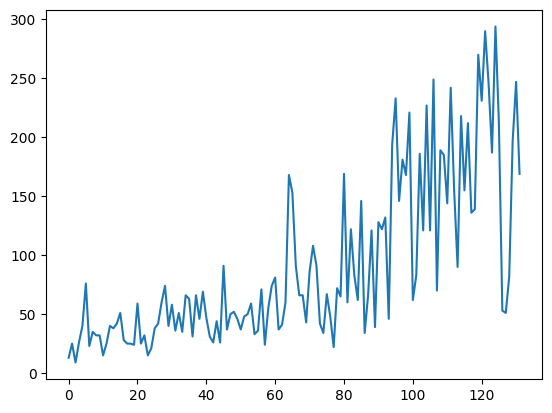

In [25]:
plt.plot(full_rewards)
plt.show()